In [230]:
import datetime
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean

In [3]:
# CONFIG

# NUM_CPU_CORES = multiprocessing.cpu_count()
# Forecast 13 weeks ahead into the future
FORECAST_PERIOD = 13
TARGET_COL = 'sales_qty'
RANDOM_SEED = 123

In [4]:
sales_df = pd.read_csv("../data/phase0_sales.csv")
list_columns = list(sales_df.columns)
list_dates_columns = list_columns[3:]

# Unpivot to get flat format dataframe
sales_df = sales_df.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='date_key', 
                         value_vars=list_dates_columns, value_name=TARGET_COL)


# Create new delimiter column to form unique identifier
sales_df['item_id'] = sales_df[['Client', 'Warehouse', 'Product']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
sales_df['date_key'] = pd.to_datetime(sales_df['date_key']).dt.date

In [8]:
def remove_leading_zeros(df):
    df = df.sort_values(by=['item_id', 'date_key'], ascending=True, ignore_index=True)
    df.loc[:, TARGET_COL] = df[TARGET_COL].fillna(0)
    return df[df.groupby('item_id')[TARGET_COL].cumsum().gt(0)]

preprocessed_df = remove_leading_zeros(sales_df)

In [9]:
def label_demand_type(ts_series):
    '''
    Returns a string indication the time series classification of a series
    There are 5 possible labels, 'Unknown', 'Intermittent', 'Lumpy', 'Smooth', 'Erratic'
        Parameters:
            1. ts_series: A pandas series containing time series to be classified

        Returns:
            ts_label: Time series label
    '''
    if any(ts_series.isna()):
        return "Unknown"
    
    length = ts_series['length']
    summed = ts_series['summed']
    std = ts_series['std']
    mean = ts_series['mean']
    
    if summed == 0 or mean == 0:
        ts_label = "Unknown"
    else:
        adi = length/summed
        cv2 = std/mean
        if adi >= 1.32:
            if cv2 < 0.49:
                ts_label = "Intermittent"
            else:
                ts_label = "Lumpy"
        elif cv2 < 0.49:
            ts_label = "Smooth"
        else:
            ts_label = "Erratic"
    return ts_label

def get_demand_type_flag(df, 
                         target_col, 
                         idx_cols, 
                         output_col) -> pd.DataFrame:
    '''
    Returns a dataframe containing time series classifications based on volatility and intermittency
    There are 5 possible labels, 'Unknown', 'Intermittent', 'Lumpy', 'Smooth', 'Erratic'
        Parameters:
            1. df: A grouped pandas dataframe to apply evaluation on
            2. target_col: Name of target col to do time series classification
            3. idx_cols: List of columns to aggregate against before ts classification
                                     (for eg: ['product_id', 'warehouse_id'])
            4. output_col: Name of output column containing flag generated

        Returns:
            df_result: Dataframe containing time series classification results
    '''
    df_agg = df.groupby(idx_cols).agg(
        length = (target_col, lambda x : len(x)),
        summed = (target_col, lambda x : sum(x > 0)),
        std = (target_col, lambda x : (x[x>0].std(ddof = 0))),
        mean = (target_col, lambda x : x[x>0].mean())
    )
    df_agg[output_col] = df_agg.apply(label_demand_type, axis = 1)
    df_result = df_agg.reset_index()[idx_cols + [output_col]]
    return df_result

demand_type_df = get_demand_type_flag(preprocessed_df, TARGET_COL, ['item_id'], 'demand_type')

In [11]:
sales_df = sales_df.merge(demand_type_df, on='item_id', how='left')
interm_sales_df = sales_df.query("demand_type.isin(['Intermittent', 'Lumpy'])")

In [86]:
def global_lgbm_forecast(sales_df, forecast_periods, objective='regression', mode='recursive'):
    mlf_sales_df = sales_df[['item_id', 'date_key', 'sales_qty']].copy()

    mlf_sales_df.rename(columns={
        'item_id': 'unique_id',
        'date_key': 'ds',
        'sales_qty' :'y',
    }, inplace=True)

    mlf_sales_df['ds'] = pd.to_datetime(mlf_sales_df['ds']) 

    # By default, mlforecast does forecasts recursively

    forecaster = MLForecast(
        models=LGBMRegressor(random_state=0, verbosity=-1, objective=objective),
        freq='W-MON',
        lags=[1,2,3,4,5],
        lag_transforms={
            1: [RollingMean(window_size=3), RollingMean(window_size=5), RollingMean(window_size=7)],
        },
        num_threads=1
    )

    if mode == 'direct':
        fitted_forecaster = forecaster.fit(mlf_sales_df, max_horizon=forecast_periods)
    elif mode == 'recursive':
        fitted_forecaster = forecaster.fit(mlf_sales_df)
    else:
        raise Exception("mode can only be 'recursive' or 'direct'")
    
    forecasts_df = fitted_forecaster.predict(forecast_periods)
    forecasts_df.rename(columns={
        'unique_id': 'item_id',
        'ds': 'date_key',
        'LGBMRegressor': 'forecast'
    }, inplace=True)
    forecasts_df['date_key'] = pd.to_datetime(forecasts_df['date_key']).dt.date
    return forecasts_df

global_lgbm_direct_l2_forecasts = global_lgbm_forecast(interm_sales_df, FORECAST_PERIOD, objective='regression', mode='direct')
global_lgbm_direct_tweedie_forecasts = global_lgbm_forecast(interm_sales_df, FORECAST_PERIOD, objective='tweedie', mode='direct')
global_lgbm_recur_l2_forecasts = global_lgbm_forecast(interm_sales_df, FORECAST_PERIOD, objective='regression', mode='recursive')
global_lgbm_recur_tweedie_forecasts = global_lgbm_forecast(interm_sales_df, FORECAST_PERIOD, objective='tweedie', mode='recursive')

In [94]:
global_forecasts_lst = [global_lgbm_direct_l2_forecasts, global_lgbm_direct_tweedie_forecasts, global_lgbm_recur_l2_forecasts, 
                               global_lgbm_recur_tweedie_forecasts]


global_lgbm_direct_l2_forecasts.rename(columns={'forecast': 'global_direct_lgb_l2'}, inplace=True)
global_lgbm_direct_tweedie_forecasts.rename(columns={'forecast': 'global_direct_lgb_tweedie'}, inplace=True)
global_lgbm_recur_l2_forecasts.rename(columns={'forecast': 'global_recur_lgb_l2'}, inplace=True)
global_lgbm_recur_tweedie_forecasts.rename(columns={'forecast': 'global_recur_lgb_tweedie'}, inplace=True)

global_forecasts_df = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on=['item_id', 'date_key']), global_forecasts_lst)

In [269]:
global_lgbm_direct_l2_forecasts.to_csv("../predictions/global_lgbm_direct_l2.csv", index=False)
global_lgbm_direct_tweedie_forecasts.to_csv("../predictions/global_lgbm_direct_tweedie.csv", index=False)
global_lgbm_recur_l2_forecasts.to_csv("../predictions/global_lgbm_recursive_l2.csv", index=False)
global_lgbm_recur_tweedie_forecasts.to_csv("../predictions/global_lgbm_recursive_tweedie.csv", index=False)

In [109]:
forecast_result_baseline_lkv = pd.read_csv("../predictions/baseline_lkv.csv")
forecast_result_baseline_ma3 = pd.read_csv("../predictions/baseline_ma3.csv")
forecast_result_baseline_lkv.rename(columns={'forecast': 'forecast_lkv'}, inplace=True)
forecast_result_baseline_ma3.rename(columns={'forecast': 'forecast_ma3'}, inplace=True)
forecast_result_baseline_lkv['date_key'] = pd.to_datetime(forecast_result_baseline_lkv['date_key']).dt.date
forecast_result_baseline_ma3['date_key'] = pd.to_datetime(forecast_result_baseline_ma3['date_key']).dt.date

In [111]:
compiled_forecasts = (global_forecasts_df.merge(forecast_result_baseline_lkv, on=['item_id', 'date_key'])
                                         .merge(forecast_result_baseline_ma3, on=['item_id', 'date_key'])
)

In [112]:
test_labels_df = pd.read_csv("../data/phase1_sales.csv")
list_columns = list(test_labels_df.columns)
list_dates_columns = list_columns[3:]

# Unpivot to get flat format dataframe
test_labels_df = test_labels_df.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='date_key', 
                                     value_vars=list_dates_columns, value_name=TARGET_COL)

# Create new delimiter column to form unique identifier
test_labels_df['item_id'] = test_labels_df[['Client', 'Warehouse', 'Product']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
test_labels_df['date_key'] = pd.to_datetime(test_labels_df['date_key']).dt.date
test_labels_df = test_labels_df[['item_id', 'date_key', 'sales_qty']]

In [113]:
merged_forecasts_labels = test_labels_df.merge(compiled_forecasts, on=['item_id', 'date_key'])


In [135]:
def evaluate_wape(targets, predictions):
    '''
    Returns a WAPE value (Weighted Average Percentage Error)
        Parameters:
            1. targets: A numpy array containing target values
            2. predictions: A numpy array containing forecasts

        Returns:
            wape: WAPE of predictions vs targets
    '''
    resids_summed = np.sum(abs(targets-predictions))
    targets_summed = np.sum(targets)
    if targets_summed == 0:
        return np.nan
    wape = resids_summed/targets_summed
    return wape

def evaluate_pwape(targets, predictions):
    '''
    Returns a pWAPE value (positive Weighted Average Percentage Error)
        Parameters:
            1. targets: A numpy array containing target values
            2. predictions: A numpy array containing forecasts

        Returns:
            pwape: pWAPE of predictions vs targets
    '''
    resids_summed = np.sum(np.clip(predictions - targets, 0, None))
    targets_summed = np.sum(targets)
    if targets_summed == 0:
        return np.nan
    pwape = resids_summed/targets_summed
    return pwape

def evaluate_nwape(targets, predictions):
    '''
    Returns a nWAPE value (negative Weighted Average Percentage Error)
        Parameters:
            1. targets: A numpy array containing target values
            2. predictions: A numpy array containing forecasts

        Returns:
            nwape: nWAPE of predictions vs targets
    '''
    resids_summed = np.sum(np.clip(targets - predictions, 0, None))
    targets_summed = np.sum(targets)
    if targets_summed == 0:
        return np.nan
    nwape = resids_summed/targets_summed
    return nwape

In [115]:
class Evaluator:
    def __init__(self, df, prediction_cols, 
                 group_cols_lst, 
                 target_col,
                 eval_funcs):
        '''
        Parameters:
                1. df: A pandas dataframe to apply evaluation on
                2. prediction_cols: A list of column names containing predictions to evaluate
                3. group_cols_lst: A list of column names to act as index to aggregate evaluation results against
                4. target_col: Name of target col to evaluate against
                5. eval_func: Evaluation function to apply on predictions and target col

        '''
        self.df = df
        self.prediction_cols = prediction_cols
        self.group_cols_lst = group_cols_lst
        self.target_col = target_col
        self.eval_funcs = eval_funcs

    @staticmethod
    def evaluate_predictions(df, prediction_cols, 
                         target_col, eval_func):
        '''
        Returns a dataframe containing evaluation results of indicated prediction_cols vs target col
            Parameters:
                1. df: A grouped pandas dataframe to apply evaluation on
                2. prediction_cols: A list of column names containing predictions to evaluate
                3. target_col: Name of target col to evaluate against
                4. eval_func: Evaluation function to apply on predictions and target col

            Returns:
                results_df: Dataframe containing evaluation results
        '''
        out = []
        pred_cols = []
        for col in prediction_cols:
            out.append(eval_func(df[target_col], df[col]))
            pred_cols.append(col)

        results_df = pd.DataFrame({'eval_value': out, 'prediction_type': pred_cols})
        return results_df


    def evaluate(self):
        '''
        Returns a dataframe containing evaluation results of indicated prediction_cols vs target col
            Returns:
                eval_df: Dataframe containing evaluation results
        '''
        eval_dfs_lst = []
        for eval_func in self.eval_funcs:
            eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)
                                          .apply(lambda x : Evaluator.evaluate_predictions(x, self.prediction_cols,
                                                                                 self.target_col, 
                                                                                 eval_func))).reset_index()
            eval_df['eval_function'] = eval_func.__name__
            
            eval_dfs_lst.append(eval_df)
        eval_final_df = pd.concat(eval_dfs_lst)
        eval_final_df.sort_values(by=self.group_cols_lst, inplace=True)
        eval_final_df = eval_final_df[self.group_cols_lst + ['prediction_type', 'eval_function', 'eval_value']]
        return eval_final_df

In [121]:
merged_forecasts_labels['forecast_ens_global_lgb_l2'] = merged_forecasts_labels[['global_direct_lgb_l2', 'global_recur_lgb_l2']].mean(axis=1)
merged_forecasts_labels['forecast_ens_global_lgb_tweedie'] = merged_forecasts_labels[['global_direct_lgb_tweedie', 'global_recur_lgb_tweedie']].mean(axis=1)
merged_forecasts_labels['forecast_ens_global_lgb'] = merged_forecasts_labels[['global_direct_lgb_l2','global_direct_lgb_tweedie', 
                                                                              'global_recur_lgb_l2', 'global_recur_lgb_tweedie']].mean(axis=1)
merged_forecasts_labels['forecast_ens_baseline_global_lgb'] = merged_forecasts_labels[['global_direct_lgb_l2','global_direct_lgb_tweedie', 
                                                                                       'global_recur_lgb_l2', 'global_recur_lgb_tweedie', 
                                                                                       'forecast_lkv', 'forecast_ma3']].mean(axis=1)

In [127]:
FORECAST_COLS = ['global_direct_lgb_l2','global_direct_lgb_tweedie', 
                'global_recur_lgb_l2', 'global_recur_lgb_tweedie', 
                'forecast_lkv', 'forecast_ma3', 'forecast_ens_global_lgb_l2',
                'forecast_ens_global_lgb_tweedie', 'forecast_ens_global_lgb',
                'forecast_ens_baseline_global_lgb']

In [182]:
merged_forecasts_labels[FORECAST_COLS] = merged_forecasts_labels[FORECAST_COLS].clip(lower=0)

In [183]:
## Create a dummy column for overall evaluation:
merged_forecasts_labels['segment'] = 'ALL'

evaluator = Evaluator(merged_forecasts_labels, 
                     FORECAST_COLS,
                     ['segment'],
                     'sales_qty', [evaluate_wape, evaluate_pwape, evaluate_nwape])
eval_report = evaluator.evaluate()

/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_85079/3134212166.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)
/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_85079/3134212166.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)
/var/folders/hj/c0k0z_096_n1727t

In [186]:
eval_report.query("eval_function == 'evaluate_wape'")

,segment,prediction_type,eval_function,eval_value
0,ALL,global_direct_lgb_l2,evaluate_wape,0.800368
9,ALL,forecast_ens_baseline_global_lgb,evaluate_wape,0.777244
8,ALL,forecast_ens_global_lgb,evaluate_wape,0.778059
7,ALL,forecast_ens_global_lgb_tweedie,evaluate_wape,0.772713
6,ALL,forecast_ens_global_lgb_l2,evaluate_wape,0.786617
5,ALL,forecast_ma3,evaluate_wape,0.799569
4,ALL,forecast_lkv,evaluate_wape,0.808897
3,ALL,global_recur_lgb_tweedie,evaluate_wape,0.786267
2,ALL,global_recur_lgb_l2,evaluate_wape,0.786237
1,ALL,global_direct_lgb_tweedie,evaluate_wape,0.767126


In [187]:
eval_report.query("prediction_type == 'forecast_ens_baseline_global_lgb'")

,segment,prediction_type,eval_function,eval_value
9,ALL,forecast_ens_baseline_global_lgb,evaluate_pwape,0.279705
9,ALL,forecast_ens_baseline_global_lgb,evaluate_wape,0.777244
9,ALL,forecast_ens_baseline_global_lgb,evaluate_nwape,0.497539


In [188]:
merged_forecasts_labels_rounded = merged_forecasts_labels.copy()
merged_forecasts_labels_rounded[FORECAST_COLS] = merged_forecasts_labels_rounded[FORECAST_COLS].round()

## Create a dummy column for overall evaluation:
merged_forecasts_labels_rounded['segment'] = 'ALL'

evaluator = Evaluator(merged_forecasts_labels_rounded, 
                     FORECAST_COLS,
                     ['segment'],
                     'sales_qty', [evaluate_wape, evaluate_pwape, evaluate_nwape])
eval_report_rounded_fcasts = evaluator.evaluate()

/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_85079/3134212166.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)
/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_85079/3134212166.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df = pd.DataFrame(self.df.groupby(self.group_cols_lst)
/var/folders/hj/c0k0z_096_n1727t

In [264]:
(eval_report_rounded_fcasts.query("eval_function == 'evaluate_wape'")
                            .query("prediction_type.isin(['global_direct_lgb_l2', 'global_recur_lgb_l2', 'global_direct_lgb_tweedie', 'global_recur_lgb_tweedie'])")
)

,segment,prediction_type,eval_function,eval_value
0,ALL,global_direct_lgb_l2,evaluate_wape,0.799712
3,ALL,global_recur_lgb_tweedie,evaluate_wape,0.819541
2,ALL,global_recur_lgb_l2,evaluate_wape,0.786432
1,ALL,global_direct_lgb_tweedie,evaluate_wape,0.758401


In [143]:
eval_report_rounded_fcasts.query("prediction_type == 'forecast_ens_baseline_global_lgb'")

,segment,prediction_type,eval_function,eval_value
9,ALL,forecast_ens_baseline_global_lgb,evaluate_pwape,0.245922
9,ALL,forecast_ens_baseline_global_lgb,evaluate_wape,0.743951
9,ALL,forecast_ens_baseline_global_lgb,evaluate_nwape,0.498029


In [190]:
for fc in FORECAST_COLS:
    col_sub_strs = fc.split("_")
    model = '_'.join(col_sub_strs[1:])
    merged_forecasts_labels[f'error_{model}'] = abs(merged_forecasts_labels['sales_qty'] - merged_forecasts_labels[fc])

In [191]:
merged_forecasts_labels['global_direct_lgb_tweedie_rounded'] = merged_forecasts_labels['global_direct_lgb_tweedie'].round()
merged_forecasts_labels[f'error_global_direct_lgb_tweedie_rounded'] = abs(merged_forecasts_labels['sales_qty'] - merged_forecasts_labels['global_direct_lgb_tweedie_rounded'])

In [192]:
merged_forecasts_labels['error_diff_l2_tweedie'] = merged_forecasts_labels['error_direct_lgb_l2'] - merged_forecasts_labels['error_global_direct_lgb_tweedie_rounded']
merged_forecasts_labels = merged_forecasts_labels.sort_values(by='error_diff_l2_tweedie', ascending=False)

In [193]:
phase1_sales_df = merged_forecasts_labels[['item_id', 'date_key', 'sales_qty']]
phase0_sales_df = preprocessed_df[['item_id', 'date_key', 'sales_qty']]
comb_sales_df = pd.concat([phase0_sales_df, phase1_sales_df])

/var/folders/hj/c0k0z_096_n1727t5kbgcvxm0000gn/T/ipykernel_85079/3187350814.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


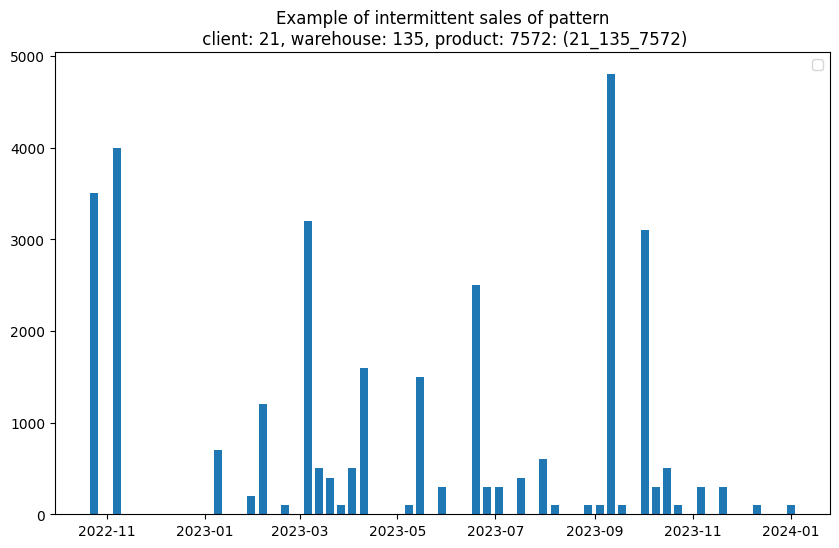

In [263]:
def visual_diagnostics_bar_chart(id, sales_df):
    client, warehouse, product = id.split("_")
    item_hist_sales_df = sales_df.query(f"item_id == '{id}'")
    item_sales_df = merged_forecasts_labels.query(f"item_id == '{id}'")
    item_sales_df = pd.concat([item_hist_sales_df[['date_key', 'sales_qty']], 
                               item_sales_df[['date_key', 'sales_qty']]])
    item_sales_df = item_sales_df.sort_values(by='date_key')

    plt.figure(figsize=(10, 6))
    plt.bar(item_sales_df['date_key'], item_sales_df['sales_qty'], width=5)
    plt.title(f"Example of intermittent sales of pattern\n client: {client}, warehouse: {warehouse}, product: {product}: ({id})")
    plt.legend()

visual_diagnostics_bar_chart('21_135_7572', comb_sales_df)

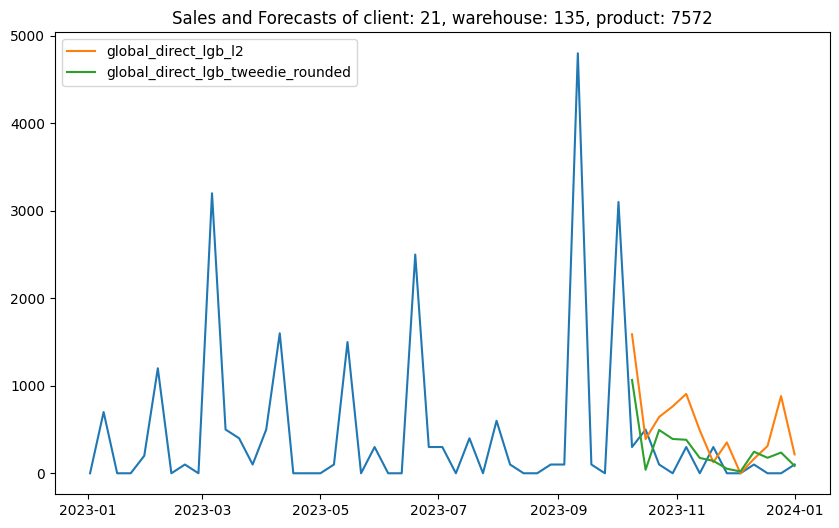

In [266]:
def visual_diagnostics(id, sales_df, forecasts_df, forecast_cols):
    client, warehouse, product = id.split("_")
    item_hist_sales_df = sales_df.query(f"item_id == '{id}'")
    item_sales_df = merged_forecasts_labels.query(f"item_id == '{id}'")
    item_sales_df = pd.concat([item_hist_sales_df[['date_key', 'sales_qty']], 
                               item_sales_df[['date_key', 'sales_qty']]])
    item_forecasts_df = merged_forecasts_labels.query(f"item_id == '{id}'")
    item_sales_df = item_sales_df.sort_values(by='date_key')
    item_forecasts_df = item_forecasts_df.sort_values(by='date_key')

    item_sales_df = item_sales_df.query("date_key >= datetime.date(2023,1,1)")
    plt.figure(figsize=(10, 6))
    plt.plot(item_sales_df['date_key'], item_sales_df['sales_qty'])
    for fc in forecast_cols:
        plt.plot(item_forecasts_df['date_key'], item_forecasts_df[fc], label=fc)
    plt.title(f"Sales and Forecasts of client: {client}, warehouse: {warehouse}, product: {product}")
    plt.legend()

visual_diagnostics('21_135_7572', sales_df, merged_forecasts_labels,  ['global_direct_lgb_l2', 'global_direct_lgb_tweedie_rounded'])